
# 8: Likelihood inference

*(note: in order to run this notebook, first run 20 creating the data and 30, adding a BDT)*


In most analysis, fitting a model to data is a crucial, last step in the chain in order to extract information about the parameters of interest.

**Model**: First, this involves building a model that depends on various parameters - some that are of immediate interest to us (Parameter Of Interest, POI) and some that help to describe the observables that we expect in the data but do not have any relevant physical meaning such as detectoreffects (Nuisance Parameter).

**Loss**: With the model and the data, a likelihood (or sometimes also a $\chi^2$ loss) is built. This is a function of the parameters and reflects the _likelihood of finding the data given the parameters_. The most likely parameter combination is retrieved when maximising the likelihood; also called the Maximum Likelihood (ML) estimator. Except for trivial cases, this has to be done numerically.

While this procedure returns an estimate of the _best-fit_, it does not say anything about the _uncertainty_ of our measurement. Therefore, advanced statistical methods are needed that perform toy studies; these are fits to generated samples under different conditions such as fixing a parameter to a certain value.

## Scope of this tutorial

Here, we focus on the libraries that are available to perform likelihood fits. For unbinned fits in Python, the libraries that we will consider here are [zfit](https://github.com/zfit/zfit) (likelihood model fitting library) and [hepstats](https://github.com/scikit-hep/hepstats) (higher level statistical inference; can use `zfit` models), both which are relatively young and written in pure Python.

An alternative to be mentioned is [RooFit](http://roofit.sourceforge.net/) and [RooStats](https://twiki.cern.ch/twiki/bin/view/RooStats/WebHome), an older, well-proven, reliable C++ framework that has Python bindings and acts as a standard in HEP for this kind of fits.

In case your analysis involved pure binned and templated fits, [pyhf](https://github.com/scikit-hep/pyhf) provides a specialized library for this kind of fits.

## Getting started

In order to get started with `zfit`, it is recommendable to have a look at the [zfit-tutorials](https://zfit-tutorials.readthedocs.io/en/latest/index.html) or the [recorded](https://www.youtube.com/playlist?list=PLAuzjeTfC3tNeP6o2sbCr3Jsa6ATvEYR6) [tutorials](https://www.youtube.com/watch?v=YDW-XxrSbns), which also contains `hepstats` tutorials; more on the latter can be found [here](https://github.com/scikit-hep/hepstats/tree/master/notebooks).

Before we continue, it is highly recommended to follow the [zfit introduction tutorial](https://zfit-tutorials.readthedocs.io/en/latest/tutorials/introduction/README.html)

In [1]:
%store -r bkg_df
%store -r mc_df
%store -r data_df

In [2]:
import hepstats
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import zfit

/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [3]:
# apply cuts
query = 'BDT > 0.4'
data_df.query(query, inplace=True)
mc_df.query(query, inplace=True)

# reduce the datasize for this example to make the fit more interesting
fraction = 0.1  # how much to take of the original data
data_df = data_df.sample(frac=0.1)

**Exercise**: write a fit to the data using `zfit`

In [4]:
obs = zfit.Space('Jpsi_M', limits=(2.8, 3.5))  # defining the observable

In [5]:
# bkg = zfit.Data.from_pandas(bkg_df['Jpsi_M'], obs=obs)
# OR
# obs_bkg = zfit.Space('Jpsi_M', limits=(2.8, 3.0)) + zfit.Space('Jpsi_M', limits=(3.2, 3.5))
# bkg_two = zfit.Data.from_pandas(data_df['Jpsi_M'], obs=obs_bkg)

In [6]:
mc = zfit.Data.from_pandas(mc_df['Jpsi_M'], obs=obs)
data = zfit.Data.from_pandas(data_df['Jpsi_M'], obs=obs)

## Difference of the two spaces

While the first space is defined over the whole space from 2.8 to 3.5, the second consists of two distinct regions. Therefore we can use the original space and zfit applies the cut, the same as we did before to the `bkg_df`.

The difference comes when using the normalization in the PDF: we can either normalize it over the whole range or only over part of it.

In [7]:
lambd = zfit.Parameter('lambda', -0.1, -2, 2)
bkg_yield = zfit.Parameter('bkg_yield', 5000, 0, 200000, step_size=1)

mu = zfit.Parameter('mu', 3.1, 2.9, 3.3)
sigma = zfit.Parameter('sigma', 0.1, 0, 0.5)
sig_yield = zfit.Parameter('sig_yield', 200, 0, 10000, step_size=1)

In [8]:
bkg_pdf = zfit.pdf.Exponential(lambd, obs=obs)
bkg_pdf.set_yield(bkg_yield)

In [9]:
sig_pdf = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)
sig_pdf.set_yield(sig_yield)

In [10]:
model = zfit.pdf.SumPDF([bkg_pdf, sig_pdf])

## Plotting

Plots can simply be made with `matplotlib` and `mplhep`.

In [11]:
def plot_fit(model, data, nbins=30, ax=None):
    # The function will be reused.
    if ax is None:
        ax = plt.gca()

    lower, upper = data.space.limit1d

    # Creates and histogram of the data and plots it with mplhep.
    counts, bin_edges = np.histogram(data.unstack_x(), bins=nbins)
    mplhep.histplot(counts, bins=bin_edges, histtype="errorbar", yerr=True,
                    label="Data", ax=ax, color="black")

    binwidth = np.diff(bin_edges)[0]
    x = np.linspace(lower, upper, num=1000)  # or tf.linspace

    # Line plots of the total pdf and the sub-pdfs.
    y = model.ext_pdf(x) * binwidth
    ax.plot(x, y, label="total", color="royalblue")
    for m, l, c in zip(model.get_models(), ["background", "signal"], ["forestgreen", "crimson"]):
        ym = m.ext_pdf(x) * binwidth
        ax.plot(x, ym, label=l, color=c)

    plt.xlabel('$J/\\psi$ mass [GeV]')
    ax.set_title(data.data_range.obs[0])
    ax.set_xlim(lower, upper)
    ax.legend(fontsize=15)

    return ax

<Axes: title={'center': 'Jpsi_M'}, xlabel='$J/\\psi$ mass [GeV]'>

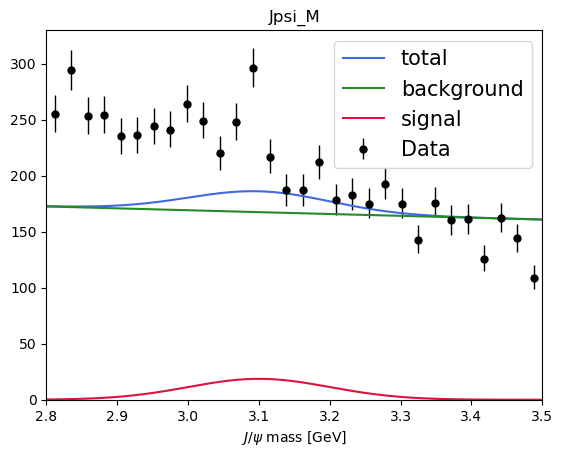

In [12]:
plot_fit(model, data)  # before the fit

## Loss

Since we have now the models and the datasets, we can e.g. pre-fit the signal PDF to the simulation.

In [13]:
sig_nll = zfit.loss.UnbinnedNLL(sig_pdf, mc)

/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/zfit/core/loss.py:933: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['extended_in_UnbinnedNLL'] = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
Extended PDFs ([<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]]) are given to a normal UnbinnedNLL.  This won't take the yield into account and simply treat the PDFs as non-extended PDFs. To create an extended NLL, use the `ExtendedUnbinnedNLL`.
  warn_advanced_feature(


It warns us that we are using a non-extended loss. The extended loss also includes to fit the yield while the normal one does not. Since we want to fit the _shape_ here only, we use the non-extended one.

In [14]:
minimizer = zfit.minimize.Minuit()
# minimizer = zfit.minimize.NLoptLBFGSV1()  # can be changed but maybe not as powerful as iminuit
# minimizer = zfit.minimize.ScipySLSQPV1()

In [15]:
minimizer.minimize(sig_nll)

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.core.data.Data object at 0x7fd10d606b50>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 5.2e-06 │             -275181.55 | -129185 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu                 3.09692       False
sigma            0.0150308       False

### Fixing parameters

Sometimes we want to fix parameters obtained from MC, such as tailes. Here we will fix the `sigma`, just for demonstration purpose.

In [16]:
sigma.floating = False

In [17]:
nll = zfit.loss.ExtendedUnbinnedNLL(model, data)

In [18]:
result = minimizer.minimize(nll)

In [19]:
result

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7fd10d5e0ed0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 3.4e-06 │             -2350.89 |  9808.028 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
bkg_yield             6037.18       False
sig_yield             139.841       False
lambda               -1.03434       False
mu                    3.09003       False

In [20]:
result.hesse()  # calculate hessian error
result.errors()  # profile, using minos like uncertainty
print(result)

/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/zfit/minimizers/fitresult.py:1361: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.errors_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of errors (which is currently the method name such as `minuit_minos`or `zfit_errors`) has changed to `errors`. Old names are still added as well for compatibility but will be removed in the future. INSTRUCTIONS: to stay compatible, change wherever you access the error to 'errors' or specify the name explicitly in errors(...).
  warn_changed_feature(message, "errors_name")


FitResult

 of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7fd10d5e0ed0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  

True

   │    True

     │      False

       │ 3.4e-06 │             -2350.89 |  9808.028 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛



Parameters


name         value  (rounded)        hesse               errors         minuit_minos    at limit
---------  ------------------  -----------  -------------------  -------------------  ----------
bkg_yield             6037.18  +/-      81  -     81   +     81  -     81   +     81       False


sig_yield             139.841  +/-      26  -     26   +     26  -     26   +     26       False


lambda               -1.03434  +/-   0.065  -  0.065   +  0.064  -  0.065   +  0.064       False


mu                    3.09003  +/-  0.0033  - 0.0034   + 0.0033  - 0.0034   + 0.0033       False

<Axes: title={'center': 'Jpsi_M'}, xlabel='$J/\\psi$ mass [GeV]'>

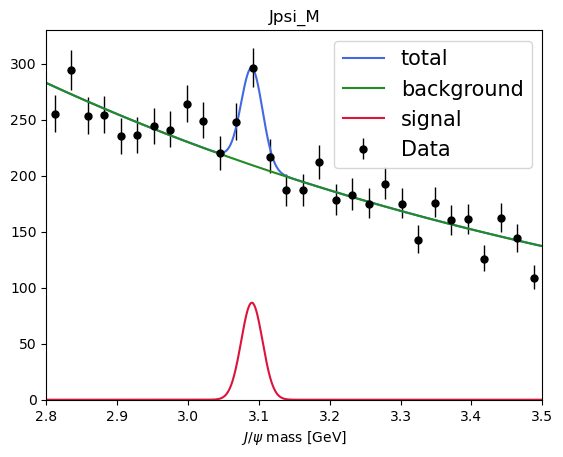

In [21]:
plot_fit(model, data)

**Exercise**: use `hepstats` to check the significance of our signal

In [22]:
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests.parameters import POI

# the null hypothesis
sig_yield_poi = POI(sig_yield, 0)
calculator = AsymptoticCalculator(input=result, minimizer=minimizer)

/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There is another calculator in `hepstats` called `FrequentistCalculator` which constructs the test statistic distribution $f(q_{0} |H_{0})$ with pseudo-experiments (toys), but it takes more time.

The `Discovery` class is a high-level class that takes as input a calculator and a `POI` instance representing the null hypothesis, it basically asks the calculator to compute the p-value and also computes the signifance as

\begin{equation}
Z = \Phi^{-1}(1 - p_0).
\end{equation}

In [23]:
from hepstats.hypotests import Discovery

discovery = Discovery(calculator=calculator, poinull=sig_yield_poi)
discovery.result()


p_value for the Null hypothesis = 2.3490038802975732e-09

Significance (in units of sigma) = 5.857530422707143

(2.3490038802975732e-09, 5.857530422707143)

**Exercise** play around! First things first: repeat the fit. The difference we will see is statistical fluctuation from the resampling of the data; we take only a fraction at random.

Change the fraction of data that we have, the BDT cut, the signal model...

Attention: it is easy to have a significance of `inf` here